# PCA in Two Different Flavors: Covariance Matrix and SVD

There are a couple of ways to perform PCA. The easier way, conceptually, is to find the eigenvectors of the covariance matrix of one's data set. However, in cases where the data matrix has many more features than samples, the covariance matrix may not be singular, and thus, may not be invertible.

### The Basics: How do we do PCA the covariance way?

Let's let $X$ be our data matrix, where the rows are samples (different measurements), and the columns are features of each measurement. For instance, in an fMRI experiment, each row could be a measurement timepoint (a TR), and each column could be the % BOLD Signal Change within each voxel. Let $m$ be the number of measurements, and $n$ be the number of voxels we measure. We thus say that 

$$X \in \mathbb{R}^{m x n} $$

The covariance matrix of $X$ is given by 

$$C = \frac{X^TX}{(n-1)} $$

with $C \in \mathbb{R}^{n x n}$

The principal directions of $X$ are given by the eigenvectors of $C$. Let's do this in MATLAB using the function $eig()$ for our toy fMRI example.

### Making fake fMRI data (feel free to skip this part)

I'm going to make fake fMRI data by generating a random event train (impulse responses) and convolving with a hemodynamic response function (HRF)

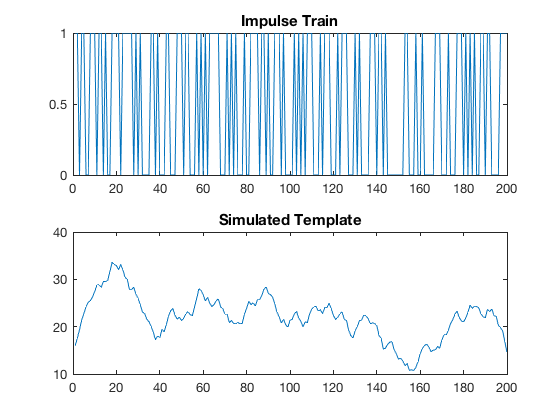

In [1]:
m = 200; % number of timepoints
n = 30; % number of voxels


hrf_x = 0:20;
HRF = hrf_x .* exp(-hrf_x/8) - 2 * hrf_x .* exp(-hrf_x/.2);

impulse_train = randi([0,1],m,1);

template = conv(impulse_train, HRF,'same');

figure();
subplot(2,1,1);
plot(1:m,impulse_train);
title('Impulse Train');
subplot(2,1,2);
plot(1:m,template);
title('Simulated Template');

In [2]:
X = zeros(m,n);

for voxel_number = 1:n
    X(:,voxel_number) = template + rand([m,1])*5;
end

row_mean = mean(X,2);
X = X - repmat(row_mean, [1,n]);

### You can check back in here if you skipped that part

X is now ready! Let's take a look at it

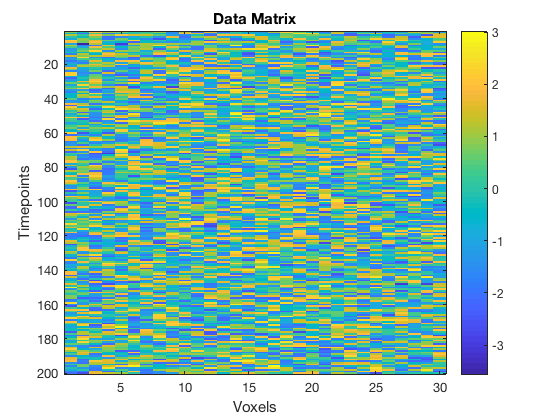

In [3]:
figure();
imagesc(X);
xlabel('Voxels');
ylabel('Timepoints');
title('Data Matrix');
colorbar();

Now let's center our data and build the covariance matrix for X

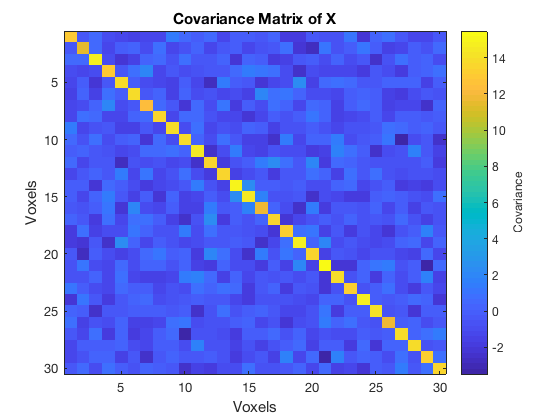

In [4]:
C = (X' * X) ./ (n-1);
figure();
imagesc(C);
xlabel('Voxels');
ylabel('Voxels');
cb = colorbar();
ylabel(cb,'Covariance');
title('Covariance Matrix of X');

So far, so good! $C$ is a symmetric matrix, so we can find its eigenvectors if it is diagonalizable. That is, we can find $V$ and $L$, where $V$ is a matrix of eigenvectors (one per column) and $L$ is a diagonal matrix of eigenvalues, such that

$$C = VLV^T$$

Note that C is not guaranteed to be diagonalizable, since it might not be full-rank if $n >> m$. This point is rather important, and we'll return to it later.

In [5]:
[V, L] = eig(C);

V is the matrix of eigenvectors (one per column), and L is a diagonal matrix with eigenvalues on the diagonal. Let's look at L.

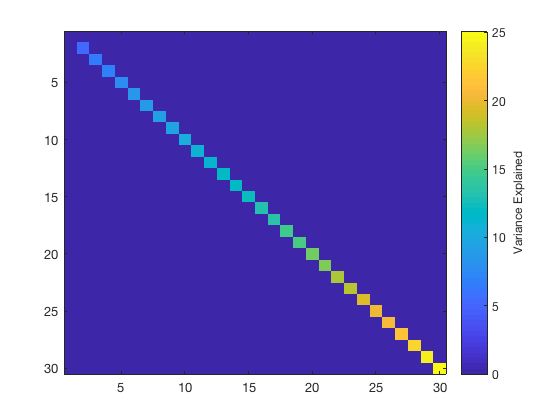

In [6]:
figure();
imagesc(L);
cb = colorbar();
ylabel(cb, 'Variance Explained');

Let's sort V and L in order of decreasing variance explained.

In [7]:
var_explained = diag(L);
[var_explained, sort_indices] = sort(var_explained,'descend');
V = V(:,sort_indices);

Finally, we can project the data onto a subset of our PCs. Let's see what our data look like projected onto the first two PCs.

In [8]:
projection = X * V(:,1:2);

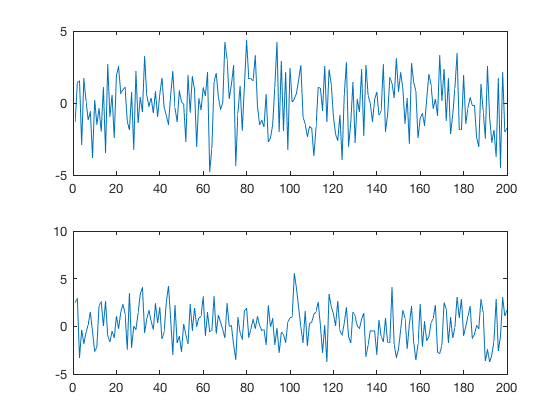

In [9]:
figure();
subplot(211);
plot(projection(:,1));
subplot(212);
plot(projection(:,2));

# Option 2: The SVD Way

Part of the problem with the method above is that the covariance matrix is not always invertible. Another problem is that practically speaking, the computation of the covariance matrix can be very time-consuming and expensive. Imagine, for example, computing $C$ for an $X$ with thousands of rows and millions of columns. Not even a supercomputer can do that efficiently. 

Singular Value Decomposition, or SVD, provides an alternative which is computationally efficient and robust to rank-deficiency in the covariance matrix. In fact, many implementations of PCA use SVD under the hood (if you don't believe me, see the help page for PCA in MATLAB below):

In [10]:
help pca

 PCA Principal Component Analysis (PCA) on raw data.
    COEFF = PCA(X) returns the principal component coefficients for the N
    by P data matrix X. Rows of X correspond to observations and columns to
    variables. Each column of COEFF contains coefficients for one principal
    component. The columns are in descending order in terms of component
    variance (LATENT). PCA, by default, centers the data and uses the
    singular value decomposition algorithm. For the non-default options,
    use the name/value pair arguments.
    
    [COEFF, SCORE] = PCA(X) returns the principal component score, which is
    the representation of X in the principal component space. Rows of SCORE
    correspond to observations, columns to components. The centered data
    can be reconstructed by SCORE*COEFF'.
 
    [COEFF, SCORE, LATENT] = PCA(X) returns the principal component
    variances, i.e., the eigenvalues of the covariance matrix of X, in
    LATENT.
 
    [COEFF, SCORE, LATENT, TSQUARED] = 

Okay, so what is SVD?

SVD decomposes any matrix $X \in \mathbb{R}^{m x n}$ into three related matrices.

$$X = USV^T$$

where $U$ contains eigenvectors of $XX^T$, $S$ is a diagonal matrix with the square root of the eigenvalues on its diagonal, and $V^T$ contains eigenvectors of $X^TX$. 

Note a few of odd things:
1. Because of the way $U$ is formed, it is an $(m x m)$ matrix.
1. Because of the way $V^T$ is formed, it is an $(n x n)$ matrix.
1. Both $U$ and $V$ are orthonormal. That'll be important later.
1. The eigenvalues of $U$ and $V^T$ are identical, so they share the matrix $S$. This is just a fact of SVD, don't @ me.

## Relating Method 1 to SVD

I'm going to be following the logic laid out in [this Stack Overflow article](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

Recall from earlier in the notebook that

$$C = \frac{X^TX}{(n-1)}$$

and

$$X = USV^T$$

Thus,

$$C = \frac{((USV^T)^T)(USV^T)}{(n-1)}$$

Bringing the transpose inside, we have
$$C = \frac{((V^T)^TS^TU^T)(USV^T)}{(n-1)}$$

The double transpose on $V$ cancels out, and $S^T == S$ because it is diagonal. We can then simplify to

$$C = \frac{(VSU^T)(USV^T)}{(n-1)}$$

*An aside: $U^TU$ is the identity matrix. Why?*
Because $U$ is orthonormal, its transpose is also its inverse. So $U^TU == U^{-1}U == I$.

Continuing to simplify, 

$$C = \frac{VSISV^T}{(n-1)}$$

We can drop the identity matrix and combine the $S$ terms to get

$$C = \frac{VS^2V^T}{(n-1)}$$

Starting to look familiar? One more thing: let's rearrange terms like this:

$$C = V\frac{S^2}{(n-1)}V^T$$

### Where are we going with this?

Let's compare two different formulations of $C$.

The first is from the PCA approach, where we just found the eigenvectors of $C$.

$$C = VLV^T$$

The second is from the SVD approach.

$$C = V\frac{S^2}{(n-1)}V^T$$

We can see that $L$ and $\frac{S^2}{(n-1)}$ are equivalent. What does that mean?

Simply, it means that the singular values in $S$ are related to the eigenvalues in $L$ such that the singular values are the normalize square roots of the eigenvalues. Cool!

## Let's do SVD
Recall that $X$ is our centered data. We're first going to construct a normalized version of $X$, which we'll call $Y$. The normalization helps keeps quantities interpretable, see the Shlens paper for details. Effectively this will deal with the need to divide by $n-1$ when converting from singular values to eigenvalues.

In [11]:
Y = X ./ sqrt(n-1);

[U,S,V] = svd(Y);
variances = diag(S) ./ diag(S); % singular values need to squared, see explanation above.
projection = U * S(:,1:2);


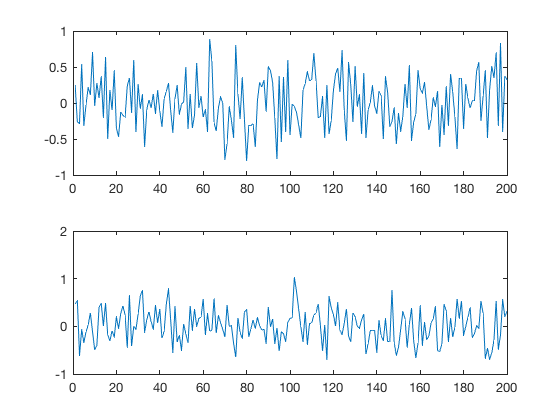

In [12]:
figure();
subplot(211);
plot(projection(:,1));
subplot(212);
plot(projection(:,2));